<a href="https://colab.research.google.com/github/ashsenth/MSDS-422/blob/main/Assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Package imports
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn import tree
from sklearn.tree import _tree
from google.colab import files
import io
uploaded = files.upload()

sns.set()
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

TARGET_F = "TARGET_BAD_FLAG"
TARGET_A = "TARGET_LOSS_AMT"

Saving HMEQ_Loss.csv to HMEQ_Loss.csv


In [2]:
#Load CSV File into df
df = pd.read_csv(io.BytesIO(uploaded['HMEQ_Loss.csv']))

#Put variables into lists (objects, integers, floats)
dt = df.dtypes
objList = []
intList = []
floatList = []

for i in dt.index:
  if i in ([TARGET_F, TARGET_A]): continue
  if dt[i] in (["object"]): objList.append(i)
  if dt[i] in (["int64"]): intList.append(i)
  if dt[i] in (["float64"]): floatList.append(i)

In [3]:
#Put variables into lists (objects, integers, floats)
dt = df.dtypes
objList = []
numList = []

for i in dt.index:
  if i in ([TARGET_F, TARGET_A]): continue
  if dt[i] in (["object"]): objList.append(i)
  if dt[i] in (["float64", "int64"]): numList.append(i)

for i in objList:
  if df[i].isna().sum() == 0: continue
  NAME = "IMP_" + i
  df[NAME] = df[i]
  df[NAME] = df[NAME].fillna("MISSING")
  g = df.groupby(NAME)
  df = df.drop(i, axis=1)

objList = []
dt = df.dtypes
for i in dt.index:
  print(" here is i .....", i , " ..... and here is the type", dt[i] )
  if i in ([TARGET_F, TARGET_A]): continue
  if dt[i] in (["object"]): objList.append(i)

#Impute categorical variables
for i in objList:
  thePrefix = "z_" + i
  y = pd.get_dummies(df[i], prefix = thePrefix, drop_first=True)
  df = pd.concat([df, y], axis=1)
  df = df.drop(i, axis=1)

print("Data\n")
print(df.head(3).T)

 here is i ..... TARGET_BAD_FLAG  ..... and here is the type int64
 here is i ..... TARGET_LOSS_AMT  ..... and here is the type float64
 here is i ..... LOAN  ..... and here is the type int64
 here is i ..... MORTDUE  ..... and here is the type float64
 here is i ..... VALUE  ..... and here is the type float64
 here is i ..... YOJ  ..... and here is the type float64
 here is i ..... DEROG  ..... and here is the type float64
 here is i ..... DELINQ  ..... and here is the type float64
 here is i ..... CLAGE  ..... and here is the type float64
 here is i ..... NINQ  ..... and here is the type float64
 here is i ..... CLNO  ..... and here is the type float64
 here is i ..... DEBTINC  ..... and here is the type float64
 here is i ..... IMP_REASON  ..... and here is the type object
 here is i ..... IMP_JOB  ..... and here is the type object
Data

                              0           1           2
TARGET_BAD_FLAG               1           1           1
TARGET_LOSS_AMT           641.0    

In [4]:
for i in numList:
  if df[i].isna().sum() == 0 : continue
  FLAG = "M_" + i
  IMP = "IMP_" + i
  # print(i)
  # print( df[i].isna().sum() )
  # print( FLAG )
  # print( IMP )
  # print(" ------- ")
  df[ FLAG ] = df[i].isna() + 0
  df[ IMP ] = df[ i ]
  df.loc[ df[IMP].isna(), IMP ] = df[i].median()
  df = df.drop( i, axis=1 )

In [5]:
#Remove Outliers
dt = df.dtypes
numList = []
for i in dt.index :
  #print(i, dt[i])
  if i in ( [ TARGET_F, TARGET_A ] ) : continue
  if dt[i] in (["float64","int64"]) : numList.append( i )

for i in numList :
  theMean = df[i].mean()
  theSD = df[i].std()
  theMax = df[i].max()
  theCutoff = round( theMean + 3*theSD )
  if theMax < theCutoff : continue
  FLAG = "O_" + i
  TRUNC = "TRUNC_" + i
  df[ FLAG ] = ( df[i] > theCutoff )+ 0
  df[ TRUNC ] = df[ i ]
  df.loc[ df[TRUNC] > theCutoff, TRUNC ] = theCutoff
  df = df.drop( i, axis=1 )

dt = df.dtypes
numList = []
for i in dt.index:
  if i in ( [ TARGET_F, TARGET_A ] ) : continue
  if dt[i] in (["float64","int64"]) : numList.append( i )

# cols_remove = [col for col in df.columns if col.startswith('O_')]
# df = df.drop(columns=cols_remove)


In [6]:
print("Data\n")
print(df.head(3).T)

Data

                              0           1           2
TARGET_BAD_FLAG               1           1           1
TARGET_LOSS_AMT           641.0      1109.0       767.0
z_IMP_REASON_HomeImp       True        True        True
z_IMP_REASON_MISSING      False       False       False
z_IMP_JOB_Mgr             False       False       False
z_IMP_JOB_Office          False       False       False
z_IMP_JOB_Other            True        True        True
z_IMP_JOB_ProfExe         False       False       False
z_IMP_JOB_Sales           False       False       False
z_IMP_JOB_Self            False       False       False
O_LOAN                        0           0           0
TRUNC_LOAN                 1100        1300        1500
O_M_MORTDUE                   0           0           0
TRUNC_M_MORTDUE               0           0           0
O_IMP_MORTDUE                 0           0           0
TRUNC_IMP_MORTDUE       25860.0     70053.0     13500.0
O_M_VALUE                     0           

In [7]:
#Split Data
X = df.copy()
X = X.drop(TARGET_F, axis = 1)
X = X.drop(TARGET_A, axis = 1)
Y = df[[TARGET_F, TARGET_A]]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, test_size = 0.2, random_state = 1)
print( "FLAG DATA" )
print( "TRAINING = ", X_train.shape )
print( "TEST = ", X_test.shape )

F = ~ Y_train[ TARGET_A ].isna()
W_train = X_train[F].copy()
Z_train = Y_train[F].copy()
F = ~ Y_test[ TARGET_A ].isna()
W_test = X_test[F].copy()
Z_test = Y_test[F].copy()

F = Z_train[ TARGET_A ] > 25000
Z_train.loc[ F, TARGET_A ] = 25000
F = Z_test[ TARGET_A ] > 25000
Z_test.loc[ F, [TARGET_A] ] = 25000


FLAG DATA
TRAINING =  (4768, 46)
TEST =  (1192, 46)


In [8]:
#Model Accuracy Metrics
def getProbAccuracyScores( NAME, MODEL, X, Y ) :
  pred = MODEL.predict( X )
  probs = MODEL.predict_proba( X )
  acc_score = metrics.accuracy_score(Y, pred)
  p1 = probs[:,1]
  fpr, tpr, threshold = metrics.roc_curve( Y, p1)
  auc = metrics.auc(fpr,tpr)
  return [NAME, acc_score, fpr, tpr, auc]

def print_ROC_Curve( TITLE, LIST ) :
  fig = plt.figure(figsize=(6,4))
  plt.title( TITLE )
  for theResults in LIST :
    NAME = theResults[0]
    fpr = theResults[2]
    tpr = theResults[3]
    auc = theResults[4]
    theLabel = "AUC " + NAME + ' %0.2f' % auc
    plt.plot(fpr, tpr, label = theLabel )
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

def print_Accuracy( TITLE, LIST ) :
  print( TITLE )
  print( "======" )
  for theResults in LIST :
    NAME = theResults[0]
    ACC = theResults[1]
    print( NAME, " = ", ACC )
  print( "------\n\n" )

def getAmtAccuracyScores( NAME, MODEL, X, Y ) :
  pred = MODEL.predict( X )
  MEAN = Y.mean()
  RMSE = math.sqrt( metrics.mean_squared_error( Y, pred))
  return [NAME, RMSE, MEAN]

In [9]:
#Functions for Coefficients of the variables in regression models

def getCoefLogit( MODEL, TRAIN_DATA ) :
  varNames = list( TRAIN_DATA.columns.values )
  coef_dict = {}
  coef_dict["INTERCEPT"] = MODEL.intercept_[0]
  for coef, feat in zip(MODEL.coef_[0],varNames):
    coef_dict[feat] = coef
  print("\nCRASH")
  print("---------")
  print("Total Variables: ", len( coef_dict ) )
  for i in coef_dict :
    print( i, " = ", coef_dict[i] )

def getCoefLinear( MODEL, TRAIN_DATA ) :
  varNames = list( TRAIN_DATA.columns.values )
  coef_dict = {}
  coef_dict["INTERCEPT"] = MODEL.intercept_
  for coef, feat in zip(MODEL.coef_,varNames):
    coef_dict[feat] = coef
  print("\nDAMAGES")
  print("---------")
  print("Total Variables: ", len( coef_dict ) )
  for i in coef_dict :
    print( i, " = ", coef_dict[i] )


#Decision Tree
def getTreeVars( TREE, varNames ) :
  tree_ = TREE.tree_
  varName = [ varNames[i] if i != _tree.TREE_UNDEFINED else "undefined!" for i in
  tree_.feature ]
  nameSet = set()
  for i in tree_.feature :
    if i != _tree.TREE_UNDEFINED :
      nameSet.add( i )
  nameList = list( nameSet )
  parameter_list = list()
  for i in nameList :
    parameter_list.append( varNames[i] )
  return parameter_list

=====
ROC CURVE FOR DECISION TREE



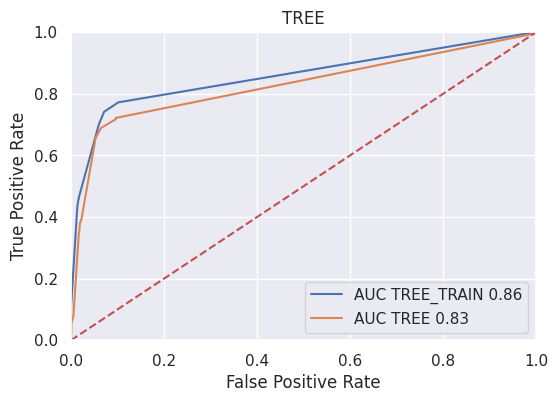

-----
TREE CLASSIFICATION ACCURACY
TREE_TRAIN  =  0.8928271812080537
TREE  =  0.886744966442953
------


TREE RMSE ACCURACY
TREE_TRAIN  =  3216.216446881694
TREE  =  3942.9974837311943
------




In [10]:
#DECISION TREE

#Probability of Loan Default
WHO = "TREE"
CLM = tree.DecisionTreeClassifier( max_depth = 4)
CLM = CLM.fit( X_train, Y_train[TARGET_F] )

TRAIN_CLM = getProbAccuracyScores( WHO + "_TRAIN", CLM, X_train, Y_train[TARGET_F])
TEST_CLM = getProbAccuracyScores( WHO, CLM, X_test, Y_test[TARGET_F] )
print("=====")
print("ROC CURVE FOR DECISION TREE\n")
print_ROC_Curve( WHO, [TRAIN_CLM, TEST_CLM])
print("-----")
print_Accuracy(WHO + " CLASSIFICATION ACCURACY", [TRAIN_CLM, TEST_CLM])

feature_cols = list(X.columns.values)
tree.export_graphviz(CLM, out_file='tree.dot', feature_names=feature_cols,
                     filled=True, rounded=True,
                     impurity=False, class_names=["Good", "Bad"])
vars_tree_flag = getTreeVars( CLM, feature_cols )

#Expected Loss if Loan Defaults
AMT = tree.DecisionTreeRegressor( max_depth = 4)
AMT = AMT.fit( W_train, Z_train[TARGET_A] )

TA1 = getAmtAccuracyScores( WHO + "_TRAIN", AMT, W_train, Z_train[TARGET_A])
TA2 = getAmtAccuracyScores( WHO, AMT, W_test, Z_test[TARGET_A])
print_Accuracy(WHO + " RMSE ACCURACY", [TA1, TA2])

feature_cols = list( X.columns.values )
vars_tree_amt = getTreeVars( AMT, feature_cols )
tree.export_graphviz(AMT,out_file='tree_a.txt',filled=True, rounded=True,
feature_names = feature_cols, impurity=False, precision=0 )

TREE_CLM = TEST_CLM.copy()
TREE_AMT = TA2.copy()

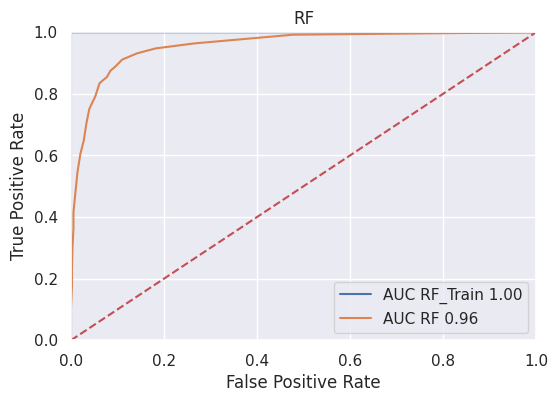



RF CLASSIFICATION ACCURACY
RF_Train  =  0.9993708053691275
RF  =  0.9119127516778524
------


RF RMSE ACCURACY
RF_Train  =  839.3402669527227
RF  =  2169.4781143648497
------




In [11]:
#RANDOM FOREST
from operator import itemgetter
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

def getEnsembleTreeVars( ENSTREE, varNames ) :
  importance = ENSTREE.feature_importances_
  index = np.argsort(importance)
  theList = []
  for i in index :
    imp_val = importance[i]
    if imp_val > np.average( ENSTREE.feature_importances_ ) :
      v = int( imp_val / np.max( ENSTREE.feature_importances_ ) * 100 )
      theList.append( ( varNames[i], v ) )
  theList = sorted(theList,key=itemgetter(1),reverse=True)
  return theList

#Probability of Loan Default
WHO = "RF"
CLM = RandomForestClassifier( n_estimators = 25, random_state=1 )
CLM = CLM.fit( X_train, Y_train[ TARGET_F ] )

TRAIN_CLM = getProbAccuracyScores( WHO + "_Train", CLM, X_train,
Y_train[ TARGET_F ] )
TEST_CLM = getProbAccuracyScores( WHO, CLM, X_test, Y_test[ TARGET_F ] )

print_ROC_Curve( WHO, [ TRAIN_CLM, TEST_CLM ] )
print("\n")
print_Accuracy( WHO + " CLASSIFICATION ACCURACY", [ TRAIN_CLM, TEST_CLM ] )
feature_cols = list( X.columns.values )
vars_RF_flag = getEnsembleTreeVars( CLM, feature_cols )

#Expected Loss if Loan Defaults
AMT = RandomForestRegressor(n_estimators = 100, random_state=1)
AMT = AMT.fit( W_train, Z_train[TARGET_A] )

TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, W_train, Z_train[TARGET_A] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, W_test, Z_test[TARGET_A] )

print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )
feature_cols = list( X.columns.values )
vars_RF_amt = getEnsembleTreeVars( AMT, feature_cols )

RF_CLM = TEST_CLM.copy()
RF_AMT = TEST_AMT.copy()


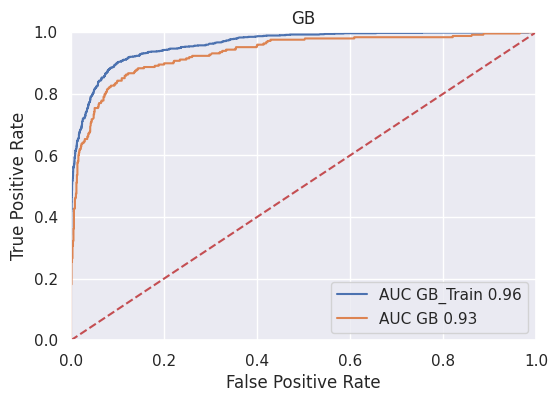



GB CLASSIFICATION ACCURACY
GB_Train  =  0.9238674496644296
GB  =  0.9060402684563759
------


GB RMSE ACCURACY
GB_Train  =  1056.527956864017
GB  =  1862.6373045150885
------


('TRUNC_LOAN', 100)
('TRUNC_IMP_CLNO', 16)
('TRUNC_IMP_DEBTINC', 8)
('TRUNC_M_DEBTINC', 7)
('TRUNC_IMP_CLAGE', 4)


In [12]:
#Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor

#Probability of Loan Default
WHO = "GB"
CLM = GradientBoostingClassifier( random_state=1 )
CLM = CLM.fit( X_train, Y_train[ TARGET_F ] )

TRAIN_CLM = getProbAccuracyScores( WHO + "_Train", CLM, X_train,
Y_train[ TARGET_F ] )
TEST_CLM = getProbAccuracyScores( WHO, CLM, X_test, Y_test[ TARGET_F ] )

print_ROC_Curve( WHO, [ TRAIN_CLM, TEST_CLM ] )
print("\n")
print_Accuracy( WHO + " CLASSIFICATION ACCURACY", [ TRAIN_CLM, TEST_CLM ] )

feature_cols = list( X.columns.values )
vars_GB_flag = getEnsembleTreeVars( CLM, feature_cols )

#Expected Loss if Loan Defaults
AMT = GradientBoostingRegressor(random_state=1)
AMT = AMT.fit( W_train, Z_train[TARGET_A] )

TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, W_train, Z_train[TARGET_A] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, W_test, Z_test[TARGET_A] )

print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )
feature_cols = list( X.columns.values )
vars_GB_amt = getEnsembleTreeVars( AMT, feature_cols )
for i in vars_GB_amt :
  print(i)

GB_CLM = TEST_CLM.copy()
GB_AMT = TEST_AMT.copy()

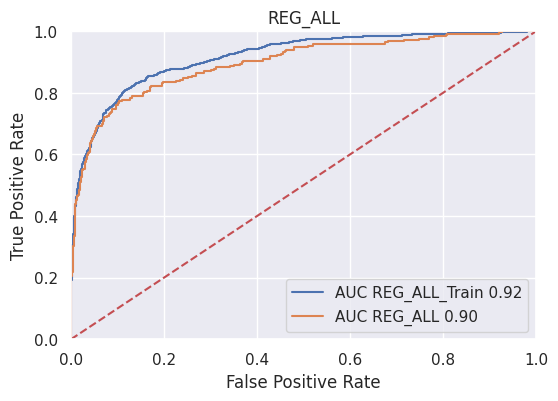

REG_ALL CLASSIFICATION ACCURACY
REG_ALL_Train  =  0.893246644295302
REG_ALL  =  0.886744966442953
------


REG_ALL RMSE ACCURACY
REG_ALL_Train  =  2810.5833219983006
REG_ALL  =  2936.1202832261365
------




In [13]:
#Regression (ALL VARIABLES)
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

#Logistic Regression
WHO = "REG_ALL"
CLM = LogisticRegression(solver='newton-cg', max_iter=10000)
CLM = CLM.fit( X_train, Y_train[TARGET_F])

TRAIN_CLM = getProbAccuracyScores( WHO + "_Train", CLM, X_train, Y_train[TARGET_F])
TEST_CLM = getProbAccuracyScores( WHO, CLM, X_test, Y_test[TARGET_F] )

print_ROC_Curve( WHO, [ TRAIN_CLM, TEST_CLM ] )
print_Accuracy( WHO + " CLASSIFICATION ACCURACY", [ TRAIN_CLM, TEST_CLM ] )

#Linear Regression
AMT = LinearRegression()
AMT = AMT.fit( W_train, Z_train[TARGET_A] )

TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, W_train, Z_train[TARGET_A] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, W_test, Z_test[TARGET_A] )
print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )

varNames = list(X_train.columns.values)

# print("\nCoefficients for Logistic and Linear Regression")
# REG_ALL_CLM_COEF = getCoefLogit( CLM, X_train )
# REG_ALL_AMT_COEF = getCoefLinear( AMT, X_train )
# print(REG_ALL_CLM_COEF)
# print("-----")
# print(REG_ALL_AMT_COEF, "\n")

REG_ALL_CLM = TEST_CLM.copy()
REG_ALL_AMT = TEST_AMT.copy()


/usr/local/lib/python3.11/dist-packages/scipy/optimize/_linesearch.py:312: LineSearchWarning: The line search algorithm did not converge
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/optimize.py:100: LineSearchWarning: The line search algorithm did not converge
  ret = line_search_wolfe2(


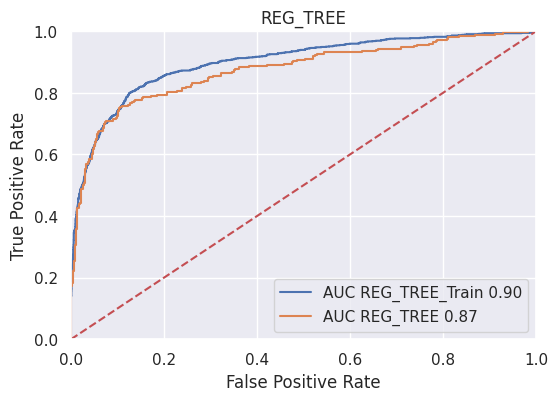

REG_TREE CLASSIFICATION ACCURACY
REG_TREE_Train  =  0.8865352348993288
REG_TREE  =  0.8791946308724832
------


REG_TREE RMSE ACCURACY
REG_TREE_Train  =  3729.745144903838
REG_TREE  =  3680.9694661222998
------




In [14]:
#Regression (DECISION TREE)
WHO = "REG_TREE"

#Logistic Regression
CLM = LogisticRegression(solver='newton-cg', max_iter=10000)
CLM = CLM.fit( X_train[vars_tree_flag], Y_train[TARGET_F])

TRAIN_CLM = getProbAccuracyScores( WHO + "_Train", CLM, X_train[vars_tree_flag],
Y_train[ TARGET_F ] )
TEST_CLM = getProbAccuracyScores( WHO, CLM, X_test[vars_tree_flag],
Y_test[ TARGET_F ] )

print_ROC_Curve( WHO, [ TRAIN_CLM, TEST_CLM ] )
print_Accuracy( WHO + " CLASSIFICATION ACCURACY", [ TRAIN_CLM, TEST_CLM ] )

#Linear Regression
AMT = LinearRegression()
AMT = AMT.fit( W_train[vars_tree_amt], Z_train[TARGET_A] )

TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, W_train[vars_tree_amt],
Z_train[ TARGET_A ] )

TEST_AMT = getAmtAccuracyScores( WHO, AMT, W_test[vars_tree_amt],
Z_test[ TARGET_A ] )
print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )

varNames = list( X_train.columns.values )
#REG_TREE_CLM_COEF = getCoefLogit( CLM, X_train[vars_tree_flag] )
#REG_TREE_AMT_COEF = getCoefLinear( AMT, X_train[vars_tree_amt] )
REG_TREE_CLM = TEST_CLM.copy()
REG_TREE_AMT = TEST_AMT.copy()




('TRUNC_M_DEBTINC', 100)
('TRUNC_IMP_DEBTINC', 76)
('TRUNC_IMP_CLAGE', 46)
('TRUNC_LOAN', 39)
('TRUNC_IMP_VALUE', 39)
('TRUNC_IMP_MORTDUE', 36)
('TRUNC_IMP_CLNO', 34)
('TRUNC_IMP_DELINQ', 33)
('TRUNC_IMP_YOJ', 30)
('TRUNC_IMP_DEROG', 21)
('TRUNC_IMP_NINQ', 20)
('O_M_VALUE', 14)



('TRUNC_LOAN', 100)
('TRUNC_IMP_CLNO', 13)
('TRUNC_IMP_DEBTINC', 10)
('TRUNC_IMP_CLAGE', 5)
('TRUNC_M_DEBTINC', 5)


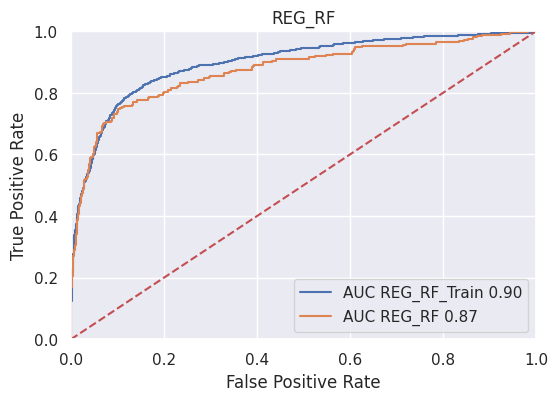

REG_RF CLASSIFICATION ACCURACY
REG_RF_Train  =  0.8798238255033557
REG_RF  =  0.87751677852349
------


REG_RF RMSE ACCURACY
REG_RF_Train  =  3477.5386484194455
REG_RF  =  3484.9713909591555
------



CRASH
---------
Total Variables:  13
INTERCEPT  =  -5.233780619465959
TRUNC_M_DEBTINC  =  2.6936636346759304
TRUNC_IMP_DEBTINC  =  0.1023744341580015
TRUNC_IMP_CLAGE  =  -0.00589063137059664
TRUNC_LOAN  =  -5.070495056209656e-06
TRUNC_IMP_VALUE  =  1.564034666428267e-06
TRUNC_IMP_MORTDUE  =  -1.1492857770051573e-06
TRUNC_IMP_CLNO  =  -0.018754397162217898
TRUNC_IMP_DELINQ  =  0.7092655860342204
TRUNC_IMP_YOJ  =  -0.011895584301357986
TRUNC_IMP_DEROG  =  0.7206630979569795
TRUNC_IMP_NINQ  =  0.13224723734757757
O_M_VALUE  =  3.5365011053368276

DAMAGES
---------
Total Variables:  6
INTERCEPT  =  -7395.372854525083
TRUNC_LOAN  =  0.5160302371830361
TRUNC_IMP_CLNO  =  252.31239889601355
TRUNC_IMP_DEBTINC  =  158.018700219304
TRUNC_IMP_CLAGE  =  -19.944120943066338
TRUNC_M_DEBTINC  =  4402.27

In [15]:
#Regression (RANDOM FOREST)

WHO = "REG_RF"

print("\n\n")
RF_flag = []
for i in vars_RF_flag :
  print(i)
  theVar = i[0]
  RF_flag.append( theVar )

print("\n\n")
RF_amt = []
for i in vars_RF_amt :
  print(i)
  theVar = i[0]
  RF_amt.append( theVar )

#Logistic Regression

CLM = LogisticRegression( solver='newton-cg', max_iter=1000 )
CLM = CLM.fit( X_train[RF_flag], Y_train[ TARGET_F ] )

TRAIN_CLM = getProbAccuracyScores( WHO + "_Train", CLM, X_train[RF_flag],
Y_train[ TARGET_F ] )
TEST_CLM = getProbAccuracyScores( WHO, CLM, X_test[RF_flag], Y_test[ TARGET_F ] )

print_ROC_Curve( WHO, [ TRAIN_CLM, TEST_CLM ] )
print_Accuracy( WHO + " CLASSIFICATION ACCURACY", [ TRAIN_CLM, TEST_CLM ] )

#Linear Regression
AMT = LinearRegression()
AMT = AMT.fit( W_train[RF_amt], Z_train[TARGET_A] )

TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, W_train[RF_amt],
Z_train[TARGET_A] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, W_test[RF_amt], Z_test[TARGET_A] )

print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )
REG_RF_CLM_COEF = getCoefLogit( CLM, X_train[RF_flag] )
REG_RF_AMT_COEF = getCoefLinear( AMT, X_train[RF_amt] )

REG_RF_CLM = TEST_CLM.copy()
REG_RF_AMT = TEST_AMT.copy()




('TRUNC_M_DEBTINC', 100)
('TRUNC_IMP_DEBTINC', 29)
('TRUNC_IMP_DELINQ', 16)
('TRUNC_IMP_CLAGE', 14)
('TRUNC_IMP_DEROG', 7)
('O_M_VALUE', 7)
('TRUNC_IMP_VALUE', 5)
('TRUNC_IMP_YOJ', 5)
('TRUNC_IMP_CLNO', 5)
('TRUNC_LOAN', 4)



('TRUNC_LOAN', 100)
('TRUNC_IMP_CLNO', 16)
('TRUNC_IMP_DEBTINC', 8)
('TRUNC_M_DEBTINC', 7)
('TRUNC_IMP_CLAGE', 4)


/usr/local/lib/python3.11/dist-packages/scipy/optimize/_linesearch.py:312: LineSearchWarning: The line search algorithm did not converge
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/optimize.py:100: LineSearchWarning: The line search algorithm did not converge
  ret = line_search_wolfe2(


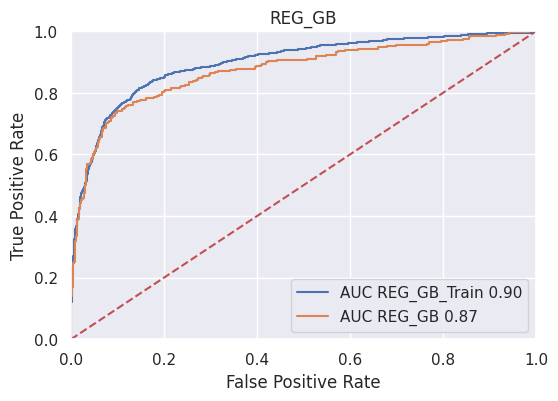

REG_GB CLASSIFICATION ACCURACY
REG_GB_Train  =  0.881501677852349
REG_GB  =  0.8800335570469798
------


REG_GB RMSE ACCURACY
REG_GB_Train  =  3477.5386484194455
REG_GB  =  3484.971390959156
------



CRASH
---------
Total Variables:  11
INTERCEPT  =  -5.192662732062279
TRUNC_M_DEBTINC  =  2.734060349727387
TRUNC_IMP_DEBTINC  =  0.10460155412145641
TRUNC_IMP_DELINQ  =  0.7058361913569345
TRUNC_IMP_CLAGE  =  -0.006121538108827982
TRUNC_IMP_DEROG  =  0.7567705938297176
O_M_VALUE  =  3.4898284891107583
TRUNC_IMP_VALUE  =  5.559943097986227e-07
TRUNC_IMP_YOJ  =  -0.013152573596874946
TRUNC_IMP_CLNO  =  -0.016258108181866182
TRUNC_LOAN  =  -2.5884983384370974e-06

DAMAGES
---------
Total Variables:  6
INTERCEPT  =  -7395.37285452504
TRUNC_LOAN  =  0.5160302371830361
TRUNC_IMP_CLNO  =  252.3123988960139
TRUNC_IMP_DEBTINC  =  158.01870021930267
TRUNC_M_DEBTINC  =  4402.276041744145
TRUNC_IMP_CLAGE  =  -19.944120943066366


In [16]:
#Regression (GRADIENT BOOSTING)

WHO = "REG_GB"

print("\n\n")
GB_flag = []
for i in vars_GB_flag :
  print(i)
  theVar = i[0]
  GB_flag.append( theVar )

print("\n\n")
GB_amt = []
for i in vars_GB_amt :
  print(i)
  theVar = i[0]
  GB_amt.append( theVar )

#Logistic Regression

CLM = LogisticRegression( solver='newton-cg', max_iter=1000 )
CLM = CLM.fit( X_train[GB_flag], Y_train[ TARGET_F ] )

TRAIN_CLM = getProbAccuracyScores( WHO + "_Train", CLM, X_train[GB_flag],
Y_train[ TARGET_F ] )
TEST_CLM = getProbAccuracyScores( WHO, CLM, X_test[GB_flag], Y_test[ TARGET_F ])

print_ROC_Curve( WHO, [ TRAIN_CLM, TEST_CLM ] )
print_Accuracy( WHO + " CLASSIFICATION ACCURACY", [ TRAIN_CLM, TEST_CLM ] )

#Linear Regression
AMT = LinearRegression()
AMT = AMT.fit( W_train[GB_amt], Z_train[TARGET_A] )
TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, W_train[GB_amt],
Z_train[TARGET_A] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, W_test[GB_amt], Z_test[TARGET_A] )
print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )
REG_GB_CLM_COEF = getCoefLogit( CLM, X_train[GB_flag] )
REG_GB_AMT_COEF = getCoefLinear( AMT, X_train[GB_amt] )
REG_GB_CLM = TEST_CLM.copy()
REG_GB_AMT = TEST_AMT.copy()

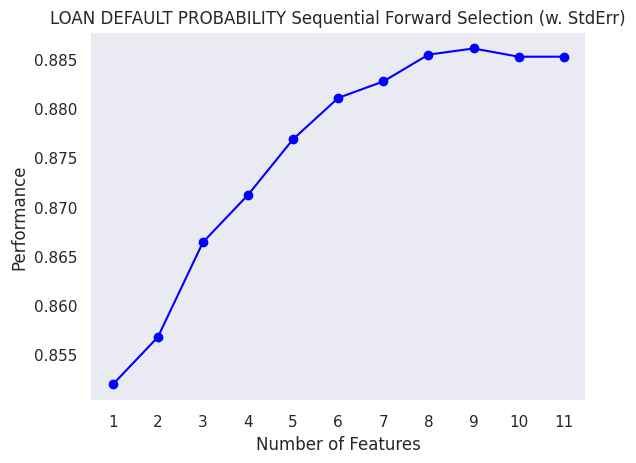

 ................... 
argmax
feature_names    (0, 1, 2, 3, 4, 7, 8, 9, 10)
avg_score                            0.886116
Name: 9, dtype: object
 ................... 
('0', '1', '2', '3', '4', '7', '8', '9', '10')
TRUNC_IMP_CLAGE
TRUNC_M_DEBTINC
TRUNC_IMP_DEBTINC
O_M_VALUE
TRUNC_IMP_MORTDUE
TRUNC_M_DEROG
TRUNC_IMP_DEROG
O_IMP_DELINQ
TRUNC_IMP_DELINQ


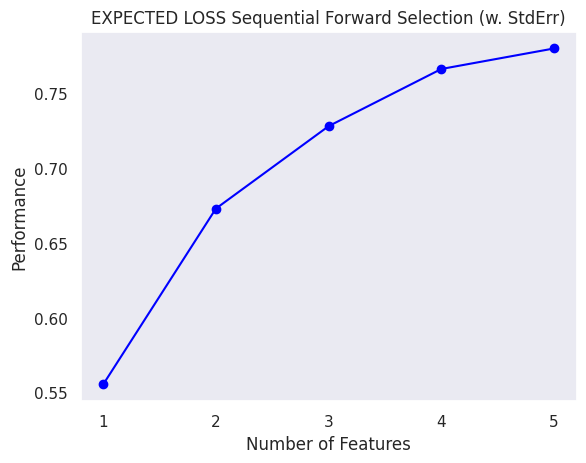

 ................... 
argmax
feature_names    (0, 1, 2, 3, 4)
avg_score                0.78027
Name: 5, dtype: object
 ................... 
('0', '1', '2', '3', '4')
TRUNC_LOAN
TRUNC_IMP_CLNO
TRUNC_IMP_DEBTINC
TRUNC_M_DEBTINC
TRUNC_IMP_CLAGE


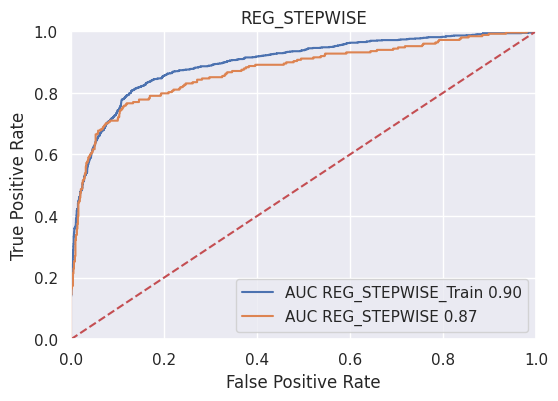

REG_STEPWISE CLASSIFICATION ACCURACY
REG_STEPWISE_Train  =  0.8856963087248322
REG_STEPWISE  =  0.8833892617449665
------


REG_STEPWISE RMSE ACCURACY
REG_STEPWISE_Train  =  3477.5386484194455
REG_STEPWISE  =  3484.971390959156
------



CRASH
---------
Total Variables:  10
INTERCEPT  =  -5.317728639152806
TRUNC_IMP_CLAGE  =  -0.006873709062007712
TRUNC_M_DEBTINC  =  2.7370168118844074
TRUNC_IMP_DEBTINC  =  0.10417400625418471
O_M_VALUE  =  3.654846054105784
TRUNC_IMP_MORTDUE  =  -9.178735372389667e-07
TRUNC_M_DEROG  =  -0.7778616264945536
TRUNC_IMP_DEROG  =  0.6923413762501456
O_IMP_DELINQ  =  1.956666894105222
TRUNC_IMP_DELINQ  =  0.6201527502041401

DAMAGES
---------
Total Variables:  6
INTERCEPT  =  -7395.37285452504
TRUNC_LOAN  =  0.5160302371830361
TRUNC_IMP_CLNO  =  252.3123988960139
TRUNC_IMP_DEBTINC  =  158.01870021930267
TRUNC_M_DEBTINC  =  4402.276041744145
TRUNC_IMP_CLAGE  =  -19.944120943066366


In [17]:
#Stepwise Regression
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import warnings
warnings.filterwarnings("ignore")

U_train = X_train[ vars_tree_flag ]
stepVarNames = list( U_train.columns.values )
maxCols = U_train.shape[1]

sfs = SFS( LogisticRegression( solver='newton-cg', max_iter=100 ),
          k_features=( 1, maxCols ),
           forward=True, floating=False, cv=3)

sfs.fit(U_train.values, Y_train[ TARGET_F ].values)
theFigure = plot_sfs(sfs.get_metric_dict(), kind=None )
plt.title('LOAN DEFAULT PROBABILITY Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

dfm = pd.DataFrame.from_dict( sfs.get_metric_dict()).T
dfm = dfm[ ['feature_names', 'avg_score'] ]
dfm.avg_score = dfm.avg_score.astype(float)

print(" ................... ")
maxIndex = dfm.avg_score.argmax()
print("argmax")
print( dfm.iloc[ maxIndex, ] )
print(" ................... ")

stepVars = dfm.iloc[ maxIndex, ]
stepVars = stepVars.feature_names
print( stepVars )

finalStepVars = []
for i in stepVars :
  index = int(i)
  try :
    theName = stepVarNames[ index ]
    finalStepVars.append( theName )
  except :
    pass

for i in finalStepVars :
  print(i)

U_train = X_train[ finalStepVars ]
U_test = X_test[ finalStepVars ]

V_train = W_train[ GB_amt ]
stepVarNames = list( V_train.columns.values )
maxCols = V_train.shape[1]

sfs = SFS( LinearRegression(),
  k_features=( 1, maxCols ),
  forward=True,
  floating=False,
  scoring = 'r2',
  cv=5
)

sfs.fit(V_train.values, Z_train[ TARGET_A ].values)

theFigure = plot_sfs(sfs.get_metric_dict(), kind=None )
plt.title('EXPECTED LOSS Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

dfm = pd.DataFrame.from_dict( sfs.get_metric_dict()).T
dfm = dfm[ ['feature_names', 'avg_score'] ]
dfm.avg_score = dfm.avg_score.astype(float)

print(" ................... ")
maxIndex = dfm.avg_score.argmax()
print("argmax")
print( dfm.iloc[ maxIndex, ] )
print(" ................... ")

stepVars = dfm.iloc[ maxIndex, ]
stepVars = stepVars.feature_names
print( stepVars )

finalStepVars = []
for i in stepVars :
  index = int(i)
  try :
    theName = stepVarNames[ index ]
    finalStepVars.append( theName )
  except :
    pass

for i in finalStepVars :
  print(i)

V_train = W_train[ finalStepVars ]
V_test = W_test[ finalStepVars ]

#Logistic Regression

WHO = "REG_STEPWISE"
CLM = LogisticRegression( solver='newton-cg', max_iter=1000 )
CLM = CLM.fit( U_train, Y_train[ TARGET_F ] )

TRAIN_CLM = getProbAccuracyScores( WHO + "_Train", CLM, U_train,
Y_train[ TARGET_F ] )
TEST_CLM = getProbAccuracyScores( WHO, CLM, U_test, Y_test[ TARGET_F ] )

print_ROC_Curve( WHO, [ TRAIN_CLM, TEST_CLM ] )
print_Accuracy( WHO + " CLASSIFICATION ACCURACY", [ TRAIN_CLM, TEST_CLM ] )

#Linear Regression

AMT = LinearRegression()
AMT = AMT.fit( V_train, Z_train[TARGET_A] )

TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, V_train, Z_train[TARGET_A] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, V_test, Z_test[TARGET_A] )
print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )

REG_STEP_CLM_COEF = getCoefLogit( CLM, U_train )
REG_STEP_AMT_COEF = getCoefLinear( AMT, V_train )

REG_STEP_CLM = TEST_CLM.copy()
REG_STEP_AMT = TEST_AMT.copy()



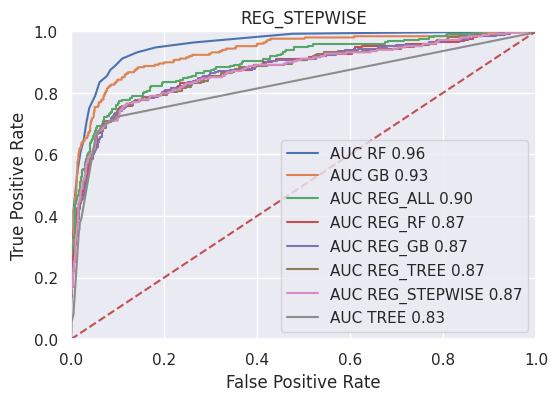

ALL CLASSIFICATION ACCURACY
RF  =  0.9119127516778524
GB  =  0.9060402684563759
REG_ALL  =  0.886744966442953
TREE  =  0.886744966442953
REG_STEPWISE  =  0.8833892617449665
REG_GB  =  0.8800335570469798
REG_TREE  =  0.8791946308724832
REG_RF  =  0.87751677852349
------


ALL LOSS AMOUNT MODEL ACCURACY
GB  =  1862.6373045150885
RF  =  2169.4781143648497
REG_ALL  =  2936.1202832261365
REG_RF  =  3484.9713909591555
REG_GB  =  3484.971390959156
REG_STEPWISE  =  3484.971390959156
REG_TREE  =  3680.9694661222998
TREE  =  3942.9974837311943
------




In [18]:
#Comparing all models
ALL_CLM = [ TREE_CLM, RF_CLM, GB_CLM, REG_ALL_CLM, REG_TREE_CLM, REG_RF_CLM,
REG_GB_CLM, REG_STEP_CLM ]
ALL_CLM = sorted( ALL_CLM, key = lambda x: x[4], reverse=True )
print_ROC_Curve( WHO, ALL_CLM )
ALL_CLM = sorted( ALL_CLM, key = lambda x: x[1], reverse=True )
print_Accuracy( "ALL CLASSIFICATION ACCURACY", ALL_CLM )
ALL_AMT = [ TREE_AMT, RF_AMT, GB_AMT, REG_ALL_AMT, REG_TREE_AMT, REG_RF_AMT,
REG_GB_AMT, REG_STEP_AMT ]
ALL_AMT = sorted( ALL_AMT, key = lambda x: x[1] )
print_Accuracy( "ALL LOSS AMOUNT MODEL ACCURACY", ALL_AMT )

149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


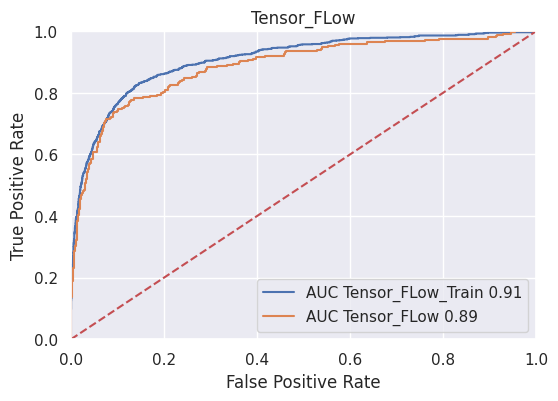

Tensor_FLow CLASSIFICATION ACCURACY
Tensor_FLow_Train  =  0.8798238255033557
Tensor_FLow  =  0.8674496644295302
------




In [19]:
#Tensorflow

import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
theScaler = MinMaxScaler()
theScaler.fit(X_train)

def get_TF_ProbAccuracyScores( NAME, MODEL, X, Y ) :
  probs = MODEL.predict( X )
  pred_list = []
  for p in probs :
    pred_list.append( np.argmax( p ) )
  pred = np.array( pred_list )
  acc_score = metrics.accuracy_score(Y, pred)
  p1 = probs[:,1]
  fpr, tpr, threshold = metrics.roc_curve( Y, p1)
  auc = metrics.auc(fpr,tpr)
  return [NAME, acc_score, fpr, tpr, auc]

WHO = "Tensor_FLow"

#Predicting Loan Defaults
U_train = theScaler.transform( X_train )
U_test = theScaler.transform( X_test )

U_train = pd.DataFrame( U_train )
U_test = pd.DataFrame( U_test )

U_train.columns = list( X_train.columns.values )
U_test.columns = list( X_train.columns.values )

U_train = U_train[ GB_flag ]
U_test = U_test[ GB_flag ]

F_theShapeSize = U_train.shape[1]
F_theActivation = tf.keras.activations.relu
F_theLossMetric = tf.keras.losses.SparseCategoricalCrossentropy()
F_theOptimizer = tf.keras.optimizers.Adam()
F_theEpochs = 100
F_theUnits = int( 2*F_theShapeSize / 3 )
F_LAYER_01 = tf.keras.layers.Dense( units=F_theUnits, activation=F_theActivation,
input_dim=F_theShapeSize )
F_LAYER_DROP = tf.keras.layers.Dropout( 0.2 )
F_LAYER_02 = tf.keras.layers.Dense( units=F_theUnits, activation=F_theActivation )
F_LAYER_OUTPUT = tf.keras.layers.Dense( units=2,
activation=tf.keras.activations.softmax )

CLM = tf.keras.Sequential()
CLM.add( F_LAYER_01 )
CLM.add( F_LAYER_DROP )
CLM.add( F_LAYER_02 )
CLM.add( F_LAYER_OUTPUT )
CLM.compile( loss=F_theLossMetric, optimizer=F_theOptimizer)
CLM.fit( U_train, Y_train[TARGET_F], epochs=F_theEpochs, verbose=False )
TRAIN_CLM = get_TF_ProbAccuracyScores( WHO + "_Train", CLM, U_train,
Y_train[ TARGET_F ] )
TEST_CLM = get_TF_ProbAccuracyScores( WHO, CLM, U_test, Y_test[ TARGET_F ] )
print_ROC_Curve( WHO, [ TRAIN_CLM, TEST_CLM ] )
print_Accuracy( WHO + " CLASSIFICATION ACCURACY", [ TRAIN_CLM, TEST_CLM ] )


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Tensor_FLow RMSE ACCURACY
Tensor_FLow_Train  =  3566.014389057403
Tensor_FLow  =  3568.260641737336
------




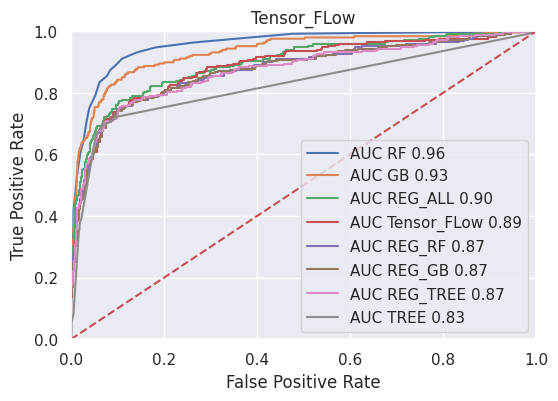

ALL CLASSIFICATION ACCURACY
RF  =  0.9119127516778524
GB  =  0.9060402684563759
REG_ALL  =  0.886744966442953
TREE  =  0.886744966442953
REG_GB  =  0.8800335570469798
REG_TREE  =  0.8791946308724832
REG_RF  =  0.87751677852349
Tensor_FLow  =  0.8674496644295302
------


ALL LOSS AMOUNT MODEL ACCURACY
GB  =  1862.6373045150885
RF  =  2169.4781143648497
REG_ALL  =  2936.1202832261365
REG_RF  =  3484.9713909591555
REG_GB  =  3484.971390959156
Tensor_FLow  =  3568.260641737336
REG_TREE  =  3680.9694661222998
TREE  =  3942.9974837311943
------




In [20]:
#Predict Loss Given Default
V_train = theScaler.transform( W_train )
V_test = theScaler.transform( W_test )
V_train = pd.DataFrame( V_train )
V_test = pd.DataFrame( V_test )
V_train.columns = list( W_train.columns.values )
V_test.columns = list( W_train.columns.values )
V_train = V_train[ GB_amt ]
V_test = V_test[ GB_amt ]

A_theShapeSize = V_train.shape[1]
A_theActivation = tf.keras.activations.relu
A_theLossMetric = tf.keras.losses.MeanSquaredError()
A_theOptimizer = tf.keras.optimizers.Adam()
A_theEpochs = 800
A_theUnits = int( 2*A_theShapeSize )
A_LAYER_01 = tf.keras.layers.Dense( units=A_theUnits, activation=A_theActivation,
input_dim=A_theShapeSize )
A_LAYER_DROP = tf.keras.layers.Dropout( 0.2 )
A_LAYER_02 = tf.keras.layers.Dense( units=A_theUnits, activation=A_theActivation )
A_LAYER_OUTPUT = tf.keras.layers.Dense( units=1,
activation=tf.keras.activations.linear )

AMT = tf.keras.Sequential()
AMT.add( A_LAYER_01 )
AMT.add( A_LAYER_DROP )
AMT.add( A_LAYER_02 )
AMT.add( A_LAYER_OUTPUT )
AMT.compile( loss=A_theLossMetric, optimizer=A_theOptimizer)
AMT.fit( V_train, Z_train[TARGET_A], epochs=A_theEpochs, verbose=False )
TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, V_train[GB_amt],
Z_train[TARGET_A] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, V_test[GB_amt], Z_test[TARGET_A] )
print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )
TF_CLM = TEST_CLM.copy()
TF_AMT = TEST_AMT.copy()

ALL_CLM = [ TREE_CLM, RF_CLM, GB_CLM, REG_ALL_CLM, REG_TREE_CLM, REG_RF_CLM,
REG_GB_CLM, TF_CLM ]
ALL_CLM = sorted( ALL_CLM, key = lambda x: x[4], reverse=True )
print_ROC_Curve( WHO, ALL_CLM )
ALL_CLM = sorted( ALL_CLM, key = lambda x: x[1], reverse=True )
print_Accuracy( "ALL CLASSIFICATION ACCURACY", ALL_CLM )
ALL_AMT = [ TREE_AMT, RF_AMT, GB_AMT, REG_ALL_AMT, REG_TREE_AMT, REG_RF_AMT,
REG_GB_AMT, TF_AMT ]
ALL_AMT = sorted( ALL_AMT, key = lambda x: x[1] )
print_Accuracy( "ALL LOSS AMOUNT MODEL ACCURACY", ALL_AMT )

# **Assignment 4 Analysis**

**1) ROC Curve Analysis for Predicting Loan Default**

From the ROC curves containing the tree-based, TF, and regression models, we can see that the Random Forest and Gradient Boosting curves are considered the most accurate. In this assignment, we added the Tensorflow model to predict loan default probability and that resulted in an accuracy of 0.89, making it the fourth most accurate model. Since Gradient Boosting is generally considered more resilient to outliers, I would recommend that over Random Forest.

**2) RMSE Analysis for Predicting Loss Amount Given Loan Default**

Based on the RMSE findings including Tensorflow, it shows Tensorflow performing pretty well in comparison to the non tree-based models. The lowest RMSE is considered the most accurate prediction model, and we get that with the TREE and REG_TREE models. Despite this, I'd still recommend Tensorflow as tree based models typically take much longer than the others.

**3) Observations and Interpretations**

Looking at the results with the Tensorflow model being added in this assignment, overall I would recommend the Tensorflow model. While it didn't score highest on both model tests, it was still in the top three for accuracy in predicting loan defaulting and predicting the loss amount. From the coefficients, I was surprised Tensorflow scored so low for the classification accuracy when it was one of the higher ROC curves and had a relatively low RMSE. I would suggest training these models on more data or running it without the outliers to see what could change. From the models listed above, I would suggest Gradient Boosting for its resiliency to outliers and fairly high scoring on both the classification and loss amount use cases.